**Note I currently have a normalization problem. 
It seems that the uncertainties are too small by a factor of ~200.
This is approximately $1 \, / \, d\Omega$ -- maybe this is a clue?
But I still think the methodology is correct, because the ratios of the uncertainties look correct.**

When solving the TIE in the AOS, we wish to estimate a set of Zernike coefficients that represent the wavefront of the telescope.
We would also like to estimate uncertainties for these coefficients.
Below, I derive the expression for these uncertainties, starting from the TIE.

## Summary

Estimating the wavefront via Zernike expansion amounts to performing parameter inference for the linear system
$$
F = M\beta
$$
where $\beta$ are the Zernike coefficients, and $F$ and $M$ are linear combinations of the compensated $I_1$ and $I_2$.
Technically, this means we have heteroscedastic correlated errors, and need to use sampling for full error propagation.
However, the uncertainties in $M$ only connect to $F$ via the Zernike coefficients $\beta$, which are very small by assumption.
Thus, the uncertainty in $M$ can be ignored.

Because $F$ is constructed via a projection onto an orthogonal basis, if the noise in $I_1$ and $I_2$ is uncorrelated and homoscedastic, then so is the noise in $F$.
In this case, the inference problem reduces to Ordinary Least Squares (OLS).
`ts_wep` already estimates the Zernike coefficients using OLS.
We can additionally calculate the covariance of the parameters using the formula
$$
C_\beta = [M^T M]^{-1} ~ \frac{\pi R^2 (1 - \varepsilon^2) \, d\Omega}{4 \, \Delta z^2} ~ (\sigma_1^2 + \sigma_2^2),
$$
where $R$ is the aperture radius, $\varepsilon$ is the fractional obscuration, $d\Omega$ is the pixel size, $\Delta z$ is the focus offset in the pupil space, and $\sigma_1, ~ \sigma_2$ are the pixel noise in the *normalized, compensated* images $I_1$ and $I_2$.

Note that for `ts_wep`, we only need the uncertainties from the last iteration of the outer loop.

### Solving the TIE with a Zernike series expansion

We are solving the Transport of Intensity Equation (TIE),

$$
\partial_z I(x, y) = - \nabla \cdot [I(x, y) ~ \nabla W(x, y)]
$$

via a series expansion in Zernike polynomials,

$$
W(x, y) = \sum_k \beta_k Z_k(x,y).
$$

If we multiply the TIE by $Z_j(x, y)$, integrate over the image $\Omega$, and integrate by parts, we get

$$
\iint d\Omega ~ Z_j(x, y) ~ \partial_z I(x, y) = \sum_k \beta_k \left[ \iint d\Omega ~ \nabla Z_j(x, y) \cdot \nabla Z_k(x,y) ~ I(x, y) \right].
$$

We can discretize over the image pixels, indexed with $a, b$. The integrals turn into summations and the factors of $d\Omega$ cancel:

$$
\sum_{a,b} (Z_j)_{ab} ~ (\partial_z I)_{ab} = \sum_k \beta_k \left[ \sum_{a,b} \, (\nabla Z_j)_{ab} \cdot (\nabla Z_k)_{ab} ~ I_{ab} \right].
$$

This is just a linear system. If we define

$$
\begin{align}
    F_j &= \sum_{a,b} (Z_j)_{ab} ~ (\partial_z I)_{ab} \\
    M_{jk} &= \sum_{a,b} \, (\nabla Z_j)_{ab} \cdot (\nabla Z_k)_{ab} ~ I_{ab},
\end{align}
$$

then we seek to solve

$$
F = M \beta
$$

for the Zernike coefficients $\beta$.
Note that $F$ is a vector, not a matrix, despite being written with a capital letter.

### Correlated errors from $\partial_z I$ and $I$

We have a linear model $F = M \beta$, and we wish to perform inference for the parameters $\beta$, given the noisy "observations" $F$ and $M$.
However, for the AOS, we don't directly measure $F$ and $M$.
In fact, we don't even directly measure $\partial_z I$ and $I$.
Instead we measure $I_1$ and $I_2$, which are images $\pm \Delta z$ out of focus.
We then approximate

$$
I = \frac{I_1 + I_2}{2} 
\quad \text{and} \quad
\partial_z I = \frac{I_1 - I_2}{2 \Delta z},
$$

and calculate $F$ and $M$ via linear combinations of pixels.
This is interesting because $F$ and $M$ are constructed from the same two images, and so their errors are correlated.
This means that we cannot naively use the usual uncertainty formulae for least squares regression.

Instead, we have an [errors-in-variables model](https://en.wikipedia.org/wiki/Errors-in-variables_models) with heteroscedasctic, correlated errors.
There is no analytic solution in this case, and you must resort to sampling methods like MCMC to fully propagate all the uncertainties.
However, in our case, we are lucky enough that the uncertainties in $M$ can be neglected, and our problem reverts to Ordinary Least Squares (OLS) with homoscedastic errors.
I will demonstrate this below.

### Propagating errors in $I_1$ and $I_2$

Assume that $I_1$ has pixel noise $\sigma_1$ and $I_2$ has pixel noise $\sigma_2$.
Note that the $I1$ and $I2$ are not the raw, or even the ISR-ed donut images -- they are the compensated images.
Thus, $\sigma_1$ and $\sigma_2$ refer to the noise level present in compensated images.
We wish to understand how this noise impacts our inference.

Every function $f$ in our system of equations is linear, so we can propagate the impact of noise using the following equation for the variance

$$
\sigma_f^2 = \sum_i \left( \frac{\partial f}{\partial x_i} \right)^2 \sigma_{x_i}^2.
$$

Applying this formula to $I$ and $\partial_z I$ yields the variances

$$
\sigma_{I}^2 = \sigma^2
\quad \text{and} \quad 
\sigma_{\partial_z I}^2 = \frac{\sigma^2}{\Delta z^2}
\quad \text{where} \quad
\sigma^2 = \frac{1}{4} (\sigma_1^2 + \sigma_2^2).
$$

If we return to the equation

$$
F = M \beta,
$$

we see that, formally, we are performing regression for the "dependent variables" $F_j$.
It makes sense, then, to calculate how the image variances propagate to $F_j$.
In particular, we wish to compare

1. $\sigma_{F_j}^2$, which is the variance in $F_j$ propagated from $\partial_z I$ through

$$
F_j = \sum_{a,b} (Z_j)_{ab} ~ (\partial_z I)_{ab},
$$

and

2. $\sigma_{\hat{F_j}}^2$, which is the variance in $F_j$ propagated from $I$ through

$$
F_j = \sum_k M_{jk} \beta_k \quad \text{where} \quad M_{jk} = \sum_{a,b} \, (\nabla Z_j)_{ab} \cdot (\nabla Z_k)_{ab} ~ I_{ab}.
$$

We will show that $\sigma_{F_j}^2 \, / \, \sigma_\hat{F_j}^2 \gg 1$, independent of $j$ and $\sigma^2$, and so we can ignore the errors on the righthand side of the equation.

### Estimating $\sigma_{F_j}^2$ and $\sigma_\hat{F_j}^2$

$\sigma_{F_j}^2$ is the variance in $F_j$ propagated from $\partial_z I$ through

$$
F_j = \sum_{a,b} (Z_j)_{ab} ~ (\partial_z I)_{ab}.
$$

Therefore,

$$
\sigma_{F_j}^2 =
\sum_{a'\!,b'} \left( \frac{\partial F_j}{\partial (\partial_z I)_{a'b'}} \right)^2 \sigma_{\partial_z I}^2 =
\frac{\sigma^2}{\Delta z^2} \sum_{a'\!,b'} \left[ \frac{\partial}{\partial (\partial_z I)_{a'b'}} \sum_{a,b} (Z_j)_{ab} ~ (\partial_z I)_{ab} \right]^2 =
\frac{\sigma^2}{\Delta z^2} \sum_{a,b} (Z_j)_{ab}^2.
$$

 ---
 
$\sigma_\hat{F_j}^2$ is the variance in $F_j$ propagated from $I$ through

$$
F_j = \sum_k M_{jk} \beta_k \quad \text{where} \quad M_{jk} = \sum_{a,b} \, (\nabla Z_j)_{ab} \cdot (\nabla Z_k)_{ab} ~ I_{ab}.
$$

Therefore,

$$
\sigma_\hat{F_j}^2 =
\sum_{a'\!,b'} \left( \frac{\partial F_j}{\partial I_{a'b'}} \right)^2 \sigma_{I}^2 =
\sigma^2 \sum_{a'\!,b'} \left[ \frac{\partial}{\partial I_{a'b'}} \sum_k \beta_k \sum_{a,b} \, (\nabla Z_j)_{ab} \cdot (\nabla Z_k)_{ab} ~ I_{ab} \right]^2 =
\sigma^2 \sum_{a,b} \left[\sum_k \beta_k \, (\nabla Z_j)_{ab} \cdot (\nabla Z_k)_{ab} \right]^2.
$$

---

To summarize,

$$
\sigma_{F_j}^2 = \frac{\sigma^2}{\Delta z^2} \sum_{a,b} (Z_j)_{ab}^2
\quad \text{and} \quad
\sigma_\hat{F_j}^2 = \sigma^2 \sum_{a,b} \left[\sum_k \beta_k \, (\nabla Z_j)_{ab} \cdot (\nabla Z_k)_{ab} \right]^2.
$$

### Estimating $\sigma_F^2 ~ / ~ \sigma_\hat{F}^2$

When we take the ratio of $\sigma_F^2$ and $\sigma_\hat{F}^2$, the variance $\sigma^2$ cancels, leaving us with

$$
\frac{\sigma_{F_j}^2}{\sigma_\hat{F_j}^2} =
\frac{
    \sum_{a,b} (Z_j)_{ab}^2
}{
    \Delta z^2 \sum_{a,b} \left[\sum_k \beta_k \, (\nabla Z_j)_{ab} \cdot (\nabla Z_k)_{ab} \right]^2
}.
$$

We can use a simple argument to see that $\sigma_F^2 \, / \, \sigma_\hat{F}^2 >> 1$.

The Zernike polynomials are defined with the following normalization

$$
\iint d\Omega ~ Z_j(x, y) Z_k(x, y) = \delta_{jk} \cdot \pi R^2 (1 - \varepsilon^2),
$$

where $R$ is the radius of the telescope aperture and $\varepsilon$ is the fractional obscuration of the telescope.
In other words, the Zernikes are orthogonal and normalized to the area of the aperture.
Thus, the scale of the Zernikes is $\mathcal{O}(1)$.
Furthermore, since we truncate the Zernike expansion at relatively low order, we expect the gradients are $\mathcal{O}(1)$.
On the other hand, we know that the perturbations the AOS corrects for are below the micron scale, so the natural scale for the $\beta_k$ is at most $\mathcal{O}(10^{-6})$.
Finally, $\Delta z$ is the defocal distance in the pupil plane and is $\mathcal{O}(10^{5})$.

Thus, independent of $j$ or $\sigma^2$, we see that

$$
\frac{\sigma_{F_j}^2}{\sigma_\hat{F_j}^2} \gtrsim \frac{1}{\left( 10^5 \right)^2 \left( 10^{-6} \right)^2} \gg 1.
$$

We are therefore justified in ignoring the uncertainties in $I$ and $M_{jk}$, and instead focusing on the uncertainties in $\partial_z I$ and $F_j$.

### Estimating the Zernike coefficients

We have a linear model $F = M \beta$, and we wish to perform inference for the parameters $\beta$.
If we ignore the uncertainty in $M$, as was justified above, then we only have uncertainties in $F$.
To proceed, we need to calculate the covariance matrix for $F$.

We have already stated that $\partial_z I$ has uncorrelated pixel variance $\sigma^2 \, / \, \Delta z^2$, i.e. 

$$
\mathrm{Cov}[\partial_z I]_{ab,a'b'} = \frac{\sigma^2}{\Delta z^2} \delta_{aa'} \delta_{bb'}.
$$

We can calculate the covariance of $F$ by generalizing our formula for error propagation above:

$$
\begin{align}
    C_{jk} 
    = \mathrm{Cov}[F]_{jk} 
    &= \sum_{a,b} \sum_{a'\!,b'} \frac{\partial F_j}{\partial (\partial_z I)_{ab}} \frac{\partial F_k}{\partial (\partial_z I)_{a'b'}} ~ \mathrm{Cov}[\partial_z I]_{ab,a'b'} \\
    &= \sum_{a,b} \sum_{a'\!,b'} (Z_j)_{ab} (Z_k)_{a'b'} \cdot \frac{\sigma^2}{\Delta z^2} \delta_{aa'} \delta_{bb'} \\
    &= \frac{\sigma^2}{\Delta z^2} \sum_{a,b} (Z_j)_{ab} (Z_k)_{ab}.
\end{align}
$$

Notice that when $j=k$, this reproduces the formula for $\sigma_{F_j}^2$ above.
We can go even further using the normalization of Zernikes above:

$$
\begin{align}
    C_{jk}
    &= \frac{\sigma^2}{\Delta z^2 \, d\Omega} \sum_{a,b} (Z_j)_{ab} (Z_k)_{ab} ~ d\Omega \\
    &= \frac{\sigma^2}{\Delta z^2 \, d\Omega} \cdot \delta_{jk} \, \pi R^2 (1 - \varepsilon^2) \\
    &\approx \left( 1.45 \cdot 10^{-6} \right) ~ \sigma^2 ~ \delta_{jk},
\end{align}
$$

where in the final line, I plug in the values for Rubin.

Notice that $C$ is proportional to the identity.
That is, we have uncorrelated homoscedastic errors.
Therefore, we can procede via Ordinary Least Squares (OLS).

`ts_wep` already performs OLS to estimate the Zernike coefficients.
We can get the covariance for the estimated coeffcients using the formula

$$
C_\beta = [M^T C^{-1} M]^{-1} = [M^T M]^{-1} \, \frac{\pi R^2 (1 - \varepsilon^2)}{\Delta z^2 \, d\Omega} ~ \sigma^2.
$$

Finally, we can plug back in $\sigma_1$ and $\sigma_2$, the pixel variance in the *compensated, normalized* $I_1$ and $I_2$, and get:

$$
C_\beta = [M^T M]^{-1} \, \frac{\pi R^2 (1 - \varepsilon^2)}{4 \, \Delta z^2 \, d\Omega} ~ (\sigma_1^2 + \sigma_2^2).
$$

### Notes for `ts_wep`

- When I was setting up my system of linear equations in the first section of this notebook, I canceled the factor of $d\Omega$ from both sides of the equations, so I wouldn't have to carry these factors around in the notebook. However, `ts_wep` uses the version of the equations that includes these factors. If we restore the factors of $d\Omega$ by making the substitution $M \to M \, / \, d\Omega$, the covariance of $\beta$ is modified to

$$
C_\beta = [M^T M]^{-1} ~ \frac{\pi R^2 (1 - \varepsilon^2) \, d\Omega}{4 \, \Delta z^2} ~ (\sigma_1^2 + \sigma_2^2).
$$

- `ts_wep` actually needs estimates of the Zernikes to compensate and normalize the images (i.e. to produce `I1` and `I2`). It then uses those images to estimate the residual wavefront, $\beta_\text{resid} = \beta_\text{truth} - \beta_\text{est}$, and does this iteratively. For error estimation, we need only consider the final iteration. For the purposes of the final iteration, $\beta_\text{est}$ is fixed, i.e. it is not a random variable, and therefore has no uncertainty associated with it. Only $\hat{\beta}_\text{resid}$ has an uncertainty. Our best estimate of the Zernikes is then $\hat{\beta}_\text{truth} = \beta_\text{est} + \hat{\beta}_\text{resid}$, with uncertainty equal to the uncertainty in $\hat{\beta}_\text{resid}$. Therefore, we only need to estimate variance during the final iteration.

- The FFT algorithm in `ts_wep` is currently broken, but it is possible to derive covariance for that algorithm as well. If we fix FFT someday, I can work on deriving that result.

### Some tests and demonstration

Below are tests with `ts_wep` that demonstrate some of the above.

In [1]:
from lsst.ts.wep.wfEstimator import WfEstimator
from lsst.ts.wep.utility import getConfigDir, DefocalType
from lsst.daf.butler import Butler

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

First we will pull out the constants, Zernike functions, etc. needed above, and run `ts_wep` on some phosim simulations so that we some compensated images and estimated Zernikes to play with.

In [2]:
closedLoopIter = 0
outerLoopIter = 14  # can be 0-14
chip = 3  # can be 0-4

# create a WfEstimator
wfEst = WfEstimator(f"{getConfigDir()}/cwfs/algo")
wfEst.config(sizeInPix=160, algo="exp", debugLevel=1)

# get the Zernike basis & gradients
zk, dzkdx, dzkdy = wfEst.algo._zernikeBasisCache()

# normalize the gradients to aperture radius
R = wfEst.algo._inst.apertureDiameter / 2.0
dzkdx = dzkdx / R
dzkdy = dzkdy / R

# construct the pupil mask
eps = wfEst.algo.getObsOfZernikes()
xSensor, ySensor = wfEst.algo._inst.getSensorCoor()
mask = (np.sqrt(xSensor**2 + ySensor**2) > eps) & (np.sqrt(xSensor**2 + ySensor**2) < 1)

# mask the Zernikes
zk = zk * mask
dzkdx = dzkdx * mask
dzkdy = dzkdy * mask

# calculate dOmega
sensorFactor = wfEst.algo._inst.getSensorFactor()
aperturePixelSize = (
    wfEst.algo._inst.apertureDiameter * sensorFactor / wfEst.algo._inst.dimOfDonutImg
)
dOmega = aperturePixelSize**2

# and Delta z = f(f-l)/l
# where f = focal length; l = defocus distance of image planes
deltaZ = (
    wfEst.algo._inst.focalLength
    * (wfEst.algo._inst.focalLength - wfEst.algo._inst.defocalDisOffsetInM)
    / wfEst.algo._inst.defocalDisOffsetInM
)

# Now, let's load an intra and extra donut stamp and run ts_wep
# first, the butler
closedloop_dir = "/phys/users/jfc20/lsst/closedLoop_outputs/exp_closedLoop_output3"
butler_repo = closedloop_dir + "/phosimData"
butler = Butler(butler_repo)
registry = butler.registry
collection = f"ts_phosim_{9006000 + closedLoopIter*10}"

# load the OPD
opd = np.genfromtxt(closedloop_dir + f"/iter{closedLoopIter}/img/opd.zer")[chip] / 1e6

# get the phosim data references from the butler
intraRef = list(registry.queryDatasets(collections=collection, datasetType="donutStampsIntra"))[chip]
extraRef = list(registry.queryDatasets(collections=collection, datasetType="donutStampsExtra"))[chip]

# pull out the intrafocal stamp from the butler
intraStamp = butler.getDirect(intraRef)[0]
img = intraStamp.stamp_im.getImage().getArray()
detector = intraStamp.getCamera().get(intraStamp.detector_name)
intraImg = rotate(img, -detector.getOrientation().getYaw().asDegrees()).T

# pull out the extrafocal stamp from the butler
extraStamp = butler.getDirect(extraRef)[0]
img = extraStamp.stamp_im.getImage().getArray()
detector = extraStamp.getCamera().get(extraStamp.detector_name)
extraImg = rotate(img, -detector.getOrientation().getYaw().asDegrees()).T

# run the algorithm
wfEst.setImg(
    intraStamp.calcFieldXY(),
    DefocalType.Intra,
    image=intraImg.copy(),
)
wfEst.setImg(
    extraStamp.calcFieldXY(),
    DefocalType.Extra,
    image=extraImg.copy(),
)
zkEstFinal = wfEst.calWfsErr()
history = wfEst.algo.getHistory()[outerLoopIter]

# now we need to determine the noise in the compensated images from the final iteration
# first, create noise images from the noise of the raw images
rng = np.random.default_rng(0)
I1, I2 = wfEst.imgIntra, wfEst.imgExtra
I1.updateImage(rng.normal(loc=1000, scale=I1.getImgInit()[:10].std(), size=I1.getImgInit().shape))
I2.updateImage(rng.normal(loc=1000, scale=I2.getImgInit()[:10].std(), size=I2.getImgInit().shape))

# then compensate both images
I1.compensate(wfEst.algo._inst, wfEst.algo, history["compZk"] / 1e9, "offAxis")
I2.compensate(wfEst.algo._inst, wfEst.algo, history["compZk"] / 1e9, "offAxis")
noisyI1, noisyI2 = I1.getImg().copy(), I2.getImg().copy()

# now, create noise-less images
I1, I2 = wfEst.imgIntra, wfEst.imgExtra
I1.updateImage(rng.normal(loc=1000, scale=0, size=I1.getImgInit().shape))
I2.updateImage(rng.normal(loc=1000, scale=0, size=I2.getImgInit().shape))

# then compensate both images
I1.compensate(wfEst.algo._inst, wfEst.algo, history["compZk"] / 1e9, "offAxis")
I2.compensate(wfEst.algo._inst, wfEst.algo, history["compZk"] / 1e9, "offAxis")
smoothI1, smoothI2 = I1.getImg().copy(), I2.getImg().copy()

# get the noise from each
noiseI1 = noisyI1 - smoothI1
noiseI2 = noisyI2 - smoothI2

# apply the same normalization that the original images received during algo._applyI1I2mask_pupil()
noiseI1 /= history["compI1"][history["pupilMask"] > 0].sum()
noiseI2 /= history["compI2"][history["pupilMask"] > 0].sum()

# finally measure the noise
sig1 = noiseI1[history["pupilMask"] > 0].std()
sig2 = noiseI2[history["pupilMask"] > 0].std()

In [3]:
# make the variance map
pixel_sum_1 = history["compI1"][history["pupilMask"] > 0].sum()
pixel_sum_2 = history["compI2"][history["pupilMask"] > 0].sum()
variance_map = (
    (history["initI1"][:10].std() ** 2 + history["compI1"]) / pixel_sum_1**2 +
    (history["initI2"][:10].std() ** 2 + history["compI2"]) / pixel_sum_2**2
) / (4 * deltaZ**2)
variance_map *= history["pupilMask"]

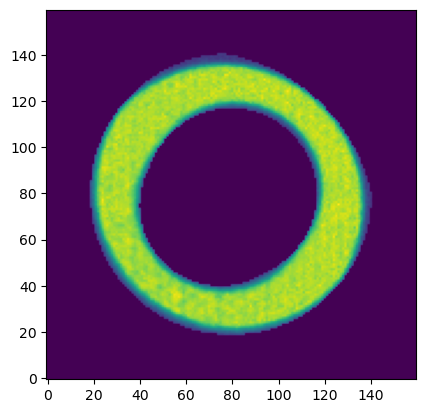

In [4]:
plt.imshow(variance_map, origin="lower")

Let's print $\sigma_1$ and $\sigma_2$, because they seem hard to measure...

In [5]:
print(f"sig1 = {sig1:.2e}")
print(f"sig2 = {sig2:.2e}")

sig1 = 3.95e-06
sig2 = 3.71e-06


Let's calculate the normalization of $C_{jk} = \left[ \frac{\pi R^2 (1-\varepsilon^2)}{\Delta z^2 \, d\Omega} \right] \sigma^2 \delta_{jk}$:

In [9]:
sigF2 = np.pi * R**2 * (1 - eps**2) / (deltaZ**2 * dOmega)
print(f"C_jk = {sigF2:.2e} * sig^2 delta_jk")

C_jk = 1.45e-06 * sig^2 delta_jk


Now we can numerically estimate $\sigma_{F_j}^2 \, / \, \sigma_\hat{F_j}^2$:

In [10]:
# load the true beta_resid from the final iteration
compZk = history["compZk"][3:] / 1e9
beta_true = np.concatenate(([0, 0, 0], opd - compZk))

# calculate sig_Fh^2
sigFh2 = np.einsum(
    "jab->j",
    np.square(
        np.einsum("k,jab,kab->jab", beta_true, dzkdx, dzkdx) +
        np.einsum("k,jab,kab->jab", beta_true, dzkdy, dzkdy)
    ),
)[3:]

# print the ratios for each j
print(f"{'j':<5}ratio\n-----------")
for j, s2 in enumerate(sigFh2):
    print(f"{j+4:<5}{sigF2/sigFh2[j]:.0f}")

j    ratio
-----------
4    496
5    3145
6    5240
7    329
8    480
9    1843
10   1742
11   87
12   376
13   227
14   925
15   1147
16   94
17   63
18   171
19   247
20   697
21   631
22   29


We can see that our assumption $\sigma_{F_j}^2 \, / \, \sigma_\hat{F_j}^2 \gg 1$ is pretty good, independent of $j$.

Next, we will demonstrate the Zernike normalization.
You can see that the inner product of Zernikes is approximately diagonal:

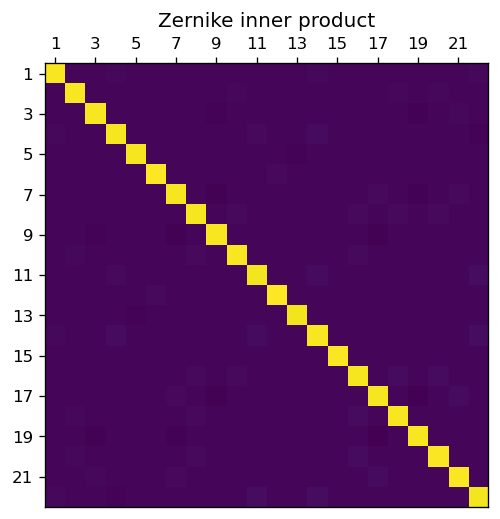

In [36]:
zk_inner_product = np.einsum("jab,kab->jk", zk, zk) * dOmega

fig, ax = plt.subplots(dpi=120)

ax.imshow(zk_inner_product)
ax.set(
    title="Zernike inner product",
    xticks=np.arange(0, len(zk), 2),
    xticklabels=np.arange(1, len(zk)+1, 2),
    yticks=np.arange(0, len(zk), 2),
    yticklabels=np.arange(1, len(zk)+1, 2),
)
ax.xaxis.tick_top()

plt.show()

However, in absolute log scale, you can see that it is not perfectly diagonal, and that the diagonal elements are not all equal to the supposed normalization.
I assume the deviation from the expected orthogonality and normalization is an artifact from pixelization?

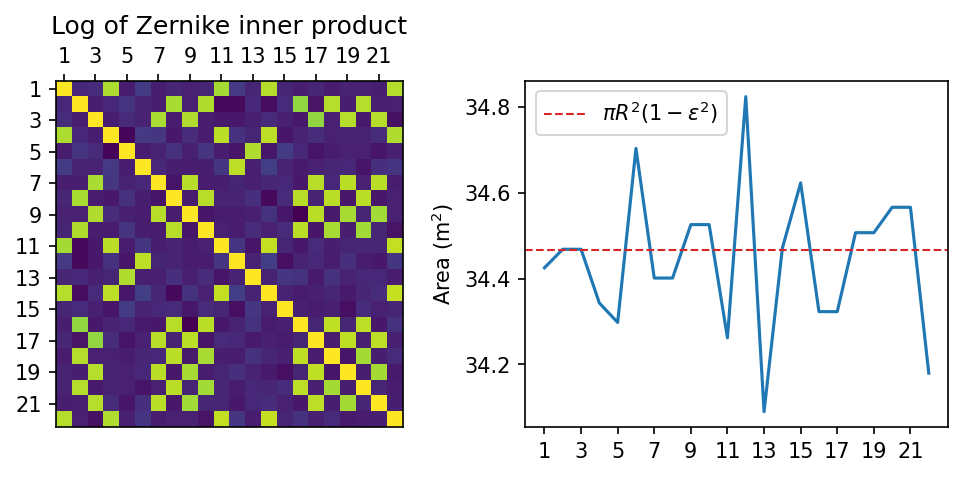

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=150)

ax1.imshow(np.log10(np.abs(zk_inner_product)))
ax1.set(
    title="Log of Zernike inner product",
    xticks=np.arange(0, len(zk), 2),
    xticklabels=np.arange(1, len(zk)+1, 2),
    yticks=np.arange(0, len(zk), 2),
    yticklabels=np.arange(1, len(zk)+1, 2),
)
ax1.xaxis.tick_top()

ax2.plot(np.arange(1, len(zk)+1), np.diag(zk_inner_product))
ax2.axhline(np.pi * R**2 * (1 - eps**2), c="C3", ls="--", lw=1, label="$\pi R^2 (1 - \epsilon^2)$")
ax2.legend()
ax2.set(
    xticks=np.arange(1, len(zk)+1, 2),
    ylabel="Area (m$^2$)",
)

plt.show()

Now let's estimate our residual Zernikes and the uncertainties!

In [6]:
# pull out the compensated images from the final iteration
I1 = history["maskedI1"] # intra
I2 = history["maskedI2"] # extra

# Calculate the image gradient and mean image
gradI = (I2 - I1) / (2 * deltaZ)
I0 = (I2 + I1) / 2

# calculate F
F = np.einsum("jab,ab->j", zk, gradI) * dOmega

# and M
M = np.einsum("jab,kab,ab->jk", dzkdx, dzkdx, I0) * dOmega
M += np.einsum("jab,kab,ab->jk", dzkdy, dzkdy, I0) * dOmega

# estimate Zernikes (this is the same thing ts_wep does)
beta = np.linalg.lstsq(M, F, rcond=None)[0][3:]

# and let's predict uncertainties! ts_wep doesn't do this! :)
# for the uncertainties, let's only use Zernikes 4 and up.
M4up = M[3:, 3:]
Cb = np.linalg.inv(M4up.T @ M4up) * np.pi * R**2 * (1 - eps**2) * dOmega / (4 * deltaZ**2) * (sig1**2 + sig2**2)

Let's plot our result along with the result from `ts_wep` and the truth, to make sure that everything is working right.

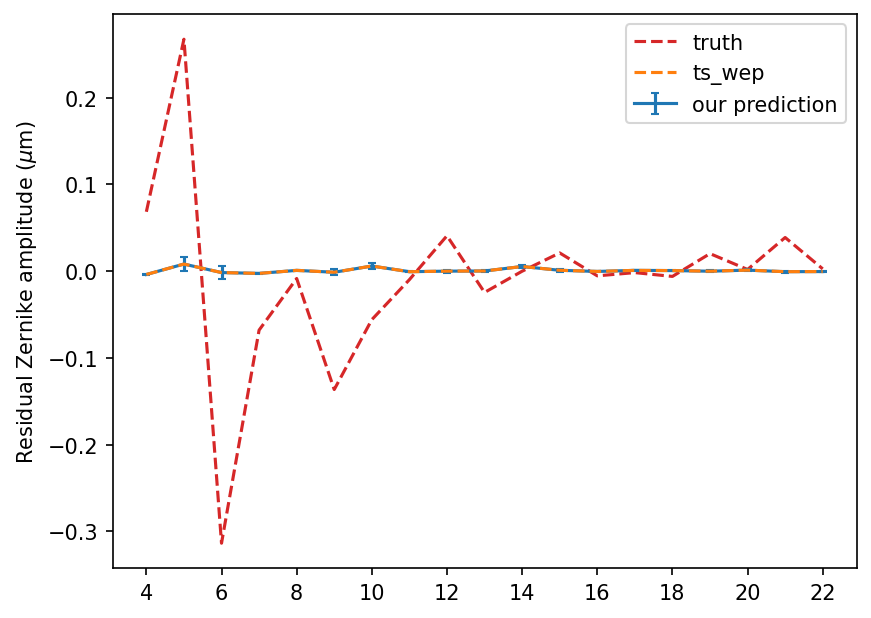

In [11]:
fig, ax = plt.subplots(dpi=150)

ax.plot(np.arange(4, len(beta)+4), beta_true[3:]*1e6, label="truth", c="C3", ls="--")
ax.errorbar(np.arange(4, len(beta)+4), beta*1e6, yerr=np.sqrt(np.diag(Cb))*1e6, label="our prediction", capsize=2)
ax.plot(np.arange(4, len(beta)+4), history["residZk"][3:] / 1e3, label="ts_wep", zorder=10, ls="--")

ax.set(xticks=np.arange(4, len(beta)+4, 2), ylabel="Residual Zernike amplitude ($\mu$m)") 
ax.legend()

plt.show()

This looks great!
Our result exactly matches `ts_wep` as it should, and the truth is within our error bars.
It looks like our error bars might be a little too big, especially for higher modes, however, this might be uncertaintiy due to degeneracies with other modes.

Let's look at the full covariance matrix for $\hat{\beta}$

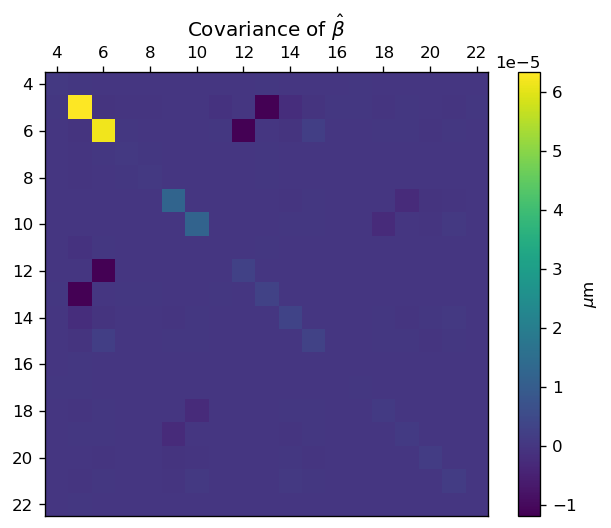

In [16]:
fig, ax = plt.subplots(dpi=120)

c = ax.imshow(Cb * 1e6**2)
ax.set(
    title="Covariance of $\hat{\\beta}$",
    xticks=np.arange(0, len(Cb), 2),
    xticklabels=np.arange(4, len(Cb)+4, 2),
    yticks=np.arange(0, len(Cb), 2),
    yticklabels=np.arange(4, len(Cb)+4, 2),
)
ax.xaxis.tick_top()

fig.colorbar(c, label="$\mu$m")

plt.show()

Looks like there is the most uncertainty for the larger modes, as expected. 
However, there is some degeneracy between modes, such as for modes 5 & 13 and 6 & 12.
The contribution of this uncertainty to modes 5 & 6 is small, but is significant for modes 12 & 13.
I think this is allowing some of the larger uncertainties for larger modes to leak into the uncertainties for smaller modes, thereby inflating their uncertainties.
However, overall there is not a lot of off-diagonal power, so reporting a variance per-mode is fairly reasonable.

Finally, let's plot our final Zernike predictions!

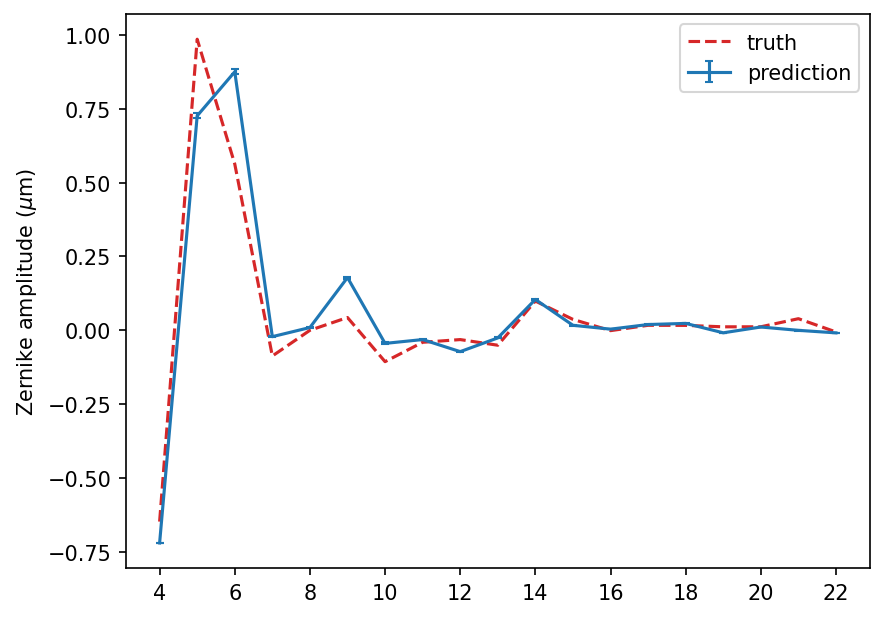

In [17]:
fig, ax = plt.subplots(dpi=150)

ax.plot(np.arange(4, len(beta)+4), opd * 1e6, label="truth", c="C3", ls="--")
ax.errorbar(np.arange(4, len(beta)+4), history["compZk"][3:] / 1e3 + beta * 1e6, yerr=np.sqrt(np.diag(Cb)) * 1e6, label="prediction", capsize=2)

ax.set(xticks=np.arange(4, len(beta)+4, 2), ylabel="Zernike amplitude ($\mu$m)") 
ax.legend()

plt.show()

Finally, let's consider the computational cost.
The most expensive step in calculating $C_\beta$ is calculating the matrix $M$ -- luckily this is already done to solve for $\beta$!
The next most expensive step is inverting $M^T M$.
Luckily, numpy is very fast at this:

In [12]:
%timeit np.linalg.inv(M4up.T @ M4up)

61.4 µs ± 4.24 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In total, calculating the covariance matrix only takes $\sim 75 \mu s$!

In [13]:
%timeit np.linalg.inv(M4up.T @ M4up) * np.pi * R**2 * (1 - eps**2) * dOmega / (4 * deltaZ**2) * (sig1**2 + sig2**2)

74.7 µs ± 1.71 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Appendix: alternate derivation of $C_{jk}$

Using the definition of covariance, $\mathrm{Cov}[F] = \mathbb{E}[(F - \bar{F})(F - \bar{F})^T]$, we have

$$
\begin{align}
    C_{jk}
    = \mathrm{Cov}[F]_{jk}
    &= \mathbb{E} \left[ 
            \sum_{a,b} (Z_j)_{ab} [(\partial_z I)_{ab} - \overline{(\partial_z I)}_{ab}] 
            \sum_{a'\!,b'} (Z_k)_{a'b'} [(\partial_z I)_{a'b'} - \overline{(\partial_z I)}_{a'b'}] 
       \right] \\
    &= \sum_{a,b} \sum_{a'\!,b'} (Z_j)_{ab} (Z_k)_{a'b'} ~
       \mathbb{E} \left[ 
             [(\partial_z I)_{ab} - \overline{(\partial_z I)}_{ab}] 
              [(\partial_z I)_{a'b'} - \overline{(\partial_z I)}_{a'b'}] 
       \right] \\
    &= \sum_{a,b} \sum_{a'\!,b'} (Z_j)_{ab} (Z_k)_{a'b'} \cdot \mathrm{Cov}[\partial_z I]_{ab,a'b'} \\
    &= \sum_{a,b} \sum_{a'\!,b'} (Z_j)_{ab} (Z_k)_{a'b'} \cdot \frac{\sigma^2}{\Delta z^2} \delta_{aa'} \delta_{bb'} \\
    &= \frac{\sigma^2}{\Delta z^2} \sum_{a,b} (Z_j)_{ab} (Z_k)_{ab},
\end{align}
$$
where in line 3, we used the definition of covariance to plug in the covariance of $\partial_z I$.

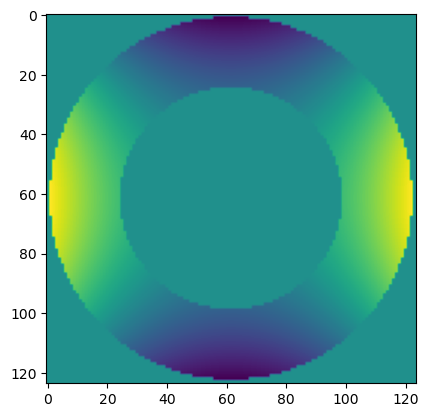

In [66]:
plt.imshow(zk[5, 18:-18, 18:-18])

In [12]:
from scipy.spatial.distance import cdist
import galsim
import pandas as pd

In [13]:
eps = wfEst.algo.getObsOfZernikes()
jmax = wfEst.algo.getNumOfZernikes()
zk = galsim.zernike.zernikeBasis(jmax, xSensor, ySensor, R_inner=eps)[1:]

mask = (np.sqrt(xSensor**2 + ySensor**2) > eps) & (np.sqrt(xSensor**2 + ySensor**2) < 1)
zk = zk * mask

In [23]:
obs = pd.read_parquet("/astro/store/epyc/users/jfc20/aos_sims/observations.parquet")
wavelens = {
    band:
    galsim.Bandpass(f"LSST_{band}.dat", wave_type='nm').effective_wavelength / 1e9
    for band in "ugrizy"
}

psf = obs["seeingFwhm500"] * obs["airmass"]**(3/5) # arcsec
r0 = 1.2 * obs["lsstFilter"].replace(wavelens) / np.deg2rad(psf / 3600) # Fried parameter
r0 = r0.median() # use the median


T = 15 # exposure time, seconds
v = 10 # expected wind velocity in dominant layer, m/s (from wfsim.atm)
t0 = 0.31 * r0/v
N = T/t0 # number of independent atmosphere realizations

In [24]:
%%time
x = R * xSensor[18:-18, 18:-18]
y = R * ySensor[18:-18, 18:-18]
points = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])
d = cdist(points, points).reshape((*x.shape, *x.shape))
D = 6.88 * (d/r0)**(5/3)

CPU times: user 20.4 s, sys: 4.01 s, total: 24.4 s
Wall time: 24.7 s


In [25]:
area = np.pi * R**2 * (1 - eps**2)

In [26]:
%%time

atm_cov = -np.einsum(
    "jab,kcd,abcd->jk",
    zk[3:, 18:-18, 18:-18] * dOmega,
    zk[3:, 18:-18, 18:-18] * dOmega,
    D,
    optimize="optimal",
) / (2 * area**2 * N)

CPU times: user 12.7 s, sys: 17.1 s, total: 29.8 s
Wall time: 485 ms


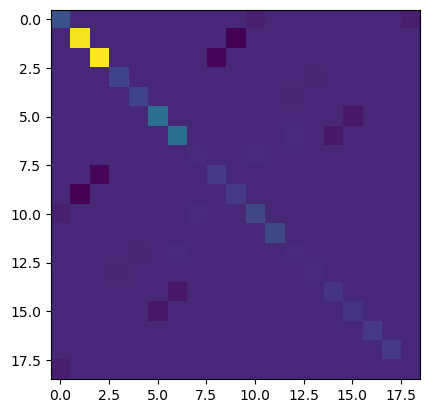

In [27]:
plt.imshow(atm_cov)

In [28]:
arcsec_per_micron = np.array(
    [
        0.751,  # Z4
        0.271,  # Z5
        0.271,  # Z6
        0.819,  # Z7
        0.819,  # Z8
        0.396,  # Z9
        0.396,  # Z10
        1.679,  # Z11
        0.937,  # Z12
        0.937,  # Z13
        0.517,  # Z14
        0.517,  # Z15
        1.755,  # Z16
        1.755,  # Z17
        1.089,  # Z18
        1.089,  # Z19
        0.635,  # Z20
        0.635,  # Z21
        2.810,  # Z22
    ]
)

In [29]:
t0

0.006869619187426561

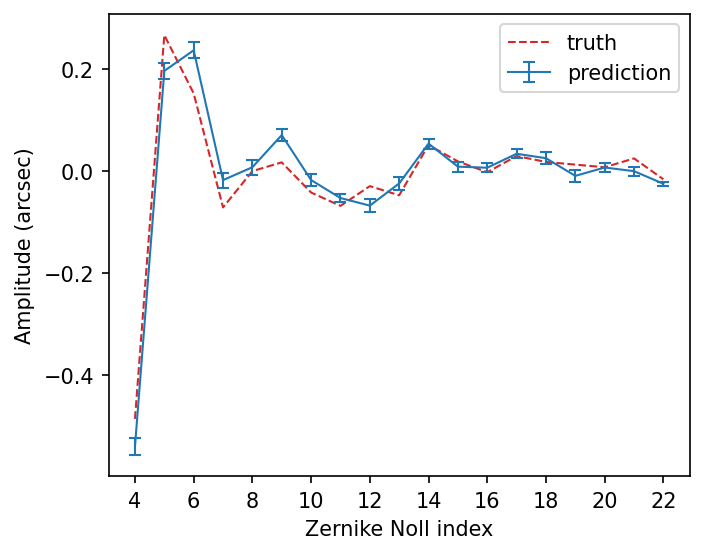

In [30]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)

ax.plot(np.arange(4, len(beta)+4), opd*1e6*arcsec_per_micron, label="truth", c="C3", ls="--", lw=1)
ax.errorbar(np.arange(4, len(beta)+4), (history["compZk"][3:]/1e3 + beta*1e6)*arcsec_per_micron, yerr=np.sqrt(np.abs(np.diag(atm_cov))/2)*arcsec_per_micron, label="prediction", capsize=3, lw=1)

ax.set(xticks=np.arange(4, len(beta)+4, 2), ylabel="Amplitude (arcsec)", xlabel="Zernike Noll index") 
ax.legend()

plt.show()

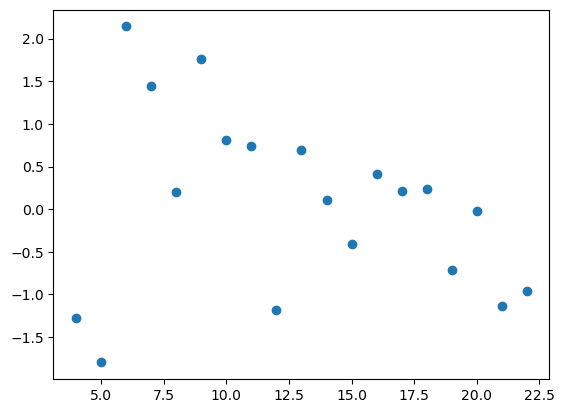

In [129]:
plt.scatter(np.arange(4, 23), ((history["compZk"][3:]/1e3 + beta*1e6) - opd*1e6) / np.sqrt(np.abs(np.diag(atm_cov))))

In [117]:
fig, ax = plt.subplots(dpi=150)

ax.plot(np.arange(4, len(beta)+4), opd * 1e6, label="truth", c="C3", ls="--")
ax.errorbar(np.arange(4, len(beta)+4), history["compZk"][3:] / 1e3 + beta * 1e6, yerr=np.sqrt(np.diag(Cb)) * 1e6, label="prediction", capsize=2)

ax.set(xticks=np.arange(4, len(beta)+4, 2), ylabel="Zernike amplitude ($\mu$m)") 
ax.legend()

plt.show()

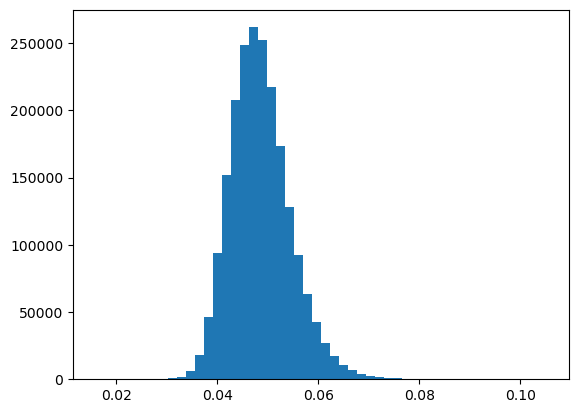

In [34]:
# expected zernike noise from the atmosphere
plt.hist(np.sqrt(np.sum(np.diag(atm_cov)/2 * arcsec_per_micron**2)) * obs["seeingFwhm500"]**(1/3) * obs["airmass"]**(1/5), bins=50);

In [35]:
np.sqrt(np.sum(np.diag(atm_cov) * arcsec_per_micron**2))

0.07264939968908342

In [32]:
obs

,observationId,boresightRa,boresightDec,boresightRotAng,lsstFilter,airmass,seeingFwhm500,skyBrightness
0,0,310.024480,-60.812928,43.832968,y,1.172534,0.515395,18.432267
1,1,310.601871,-63.561425,45.040440,y,1.207046,0.515395,18.416423
2,2,311.292611,-66.317774,45.197158,y,1.248190,0.515395,18.386746
3,3,312.140731,-69.082666,45.337850,y,1.295605,1.659211,18.351940
4,4,304.170163,-73.375442,45.446808,y,1.371481,1.659211,18.319873
...,...,...,...,...,...,...,...,...
2081744,2081744,347.124408,-44.121665,340.054663,u,1.042713,1.060400,22.265465
2081745,2081745,344.049134,-45.895531,341.366258,u,1.044786,1.119850,22.264109
2081746,2081746,340.774233,-47.593274,342.083209,u,1.049659,1.119850,22.260662
2081747,2081747,337.288929,-49.202077,342.200645,u,1.057427,1.119850,22.251608


In [113]:
obs2 = pd.read_parquet("data/metadata.parquet")
obs2[obs2["nBrightBlends"] == 1]

,pntId,obsId,objId,fx,fy,corner,intra,nBrightBlends,nFaintBlends,minDist,mag,filter,airmass,seeing,skyBrightness
9,1040691,1072558,4158932590678720000,0.022434,-0.021618,R04,True,1,19,31.937690,14.758065,i,1.258546,0.762742,20.238979
21,1505367,607389,3823137277082273280,0.022269,-0.019460,R04,True,1,2,76.488514,14.607113,u,1.073287,0.937460,22.593011
24,599975,1929176,2594865484709913856,-0.019161,0.019639,R40,False,1,0,56.259898,14.000000,z,1.515420,0.786469,18.963776
36,1129212,607389,3554395813252625920,0.021480,-0.019920,R04,True,1,1,33.311131,14.000000,u,1.073287,0.937460,22.593011
40,363794,749454,6555635048920444416,0.021213,-0.022330,R04,True,1,0,43.502893,14.051906,z,1.343727,0.678114,18.868152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27519,518118,1072558,5507516832310358400,-0.019213,-0.021357,R00,True,1,6,90.571447,14.937152,i,1.258546,0.762742,20.238979
27523,2063723,749454,4147563679122580864,0.020160,-0.019520,R04,False,1,38,18.196913,14.341109,z,1.343727,0.678114,18.868152
27537,1198307,749454,5369787058020411648,0.019541,-0.021319,R04,False,1,19,40.387272,14.186645,z,1.343727,0.678114,18.868152
27553,1413844,1941781,1173124622746043904,-0.022577,0.019562,R40,True,1,2,74.498647,14.995179,g,1.186380,0.486477,22.141732


In [132]:
[:20]

['/astro/store/epyc/users/jfc20/aos_sims/images/pnt658803.obs658803.obj3066090639090027904.image.npy',
 '/astro/store/epyc/users/jfc20/aos_sims/images/pnt658803.obs658803.obj3066053633651539584.image.npy',
 '/astro/store/epyc/users/jfc20/aos_sims/images/pnt658803.obs658803.obj3066066140596305408.image.npy',
 '/astro/store/epyc/users/jfc20/aos_sims/images/pnt658803.obs658803.obj3066052740298332160.image.npy',
 '/astro/store/epyc/users/jfc20/aos_sims/images/pnt658803.obs658803.obj3066051606427008896.image.npy',
 '/astro/store/epyc/users/jfc20/aos_sims/images/pnt658803.obs658803.obj3066051537707526784.image.npy',
 '/astro/store/epyc/users/jfc20/aos_sims/images/pnt658803.obs658803.obj3066053358773653504.image.npy',
 '/astro/store/epyc/users/jfc20/aos_sims/images/pnt658803.obs658803.obj3066053049536009728.image.npy',
 '/astro/store/epyc/users/jfc20/aos_sims/images/pnt658803.obs658803.obj3069690474518822528.image.npy',
 '/astro/store/epyc/users/jfc20/aos_sims/images/pnt658803.obs658803.obj30

In [150]:
img_files = glob.glob("/astro/store/epyc/users/jfc20/aos_sims/images/*")
obs_dict = {}
for file in img_files:
    pnt, obs = file.split("/")[-1].split(".")[:2]
    pnt = int(pnt[3:])
    obs = int(obs[3:])
    if obs in obs_dict and pnt not in obs_dict[obs]:
        obs_dict[obs].append(pnt)
    elif obs not in obs_dict:
        obs_dict[obs] = [pnt]

In [177]:
seed = 123
rng = np.random.default_rng(seed)
rng.choice(list(obs_dict.keys()), len(obs_dict), replace=False)

array([ 661845,  127266,  939774, 1655116, 2061965, 1064738,   27328,
         74066, 1394047,  965651, 1929176,  971274,  566990, 1298174,
       1272907,  549591,  851898,  764183, 1858465, 1627101, 1681259,
        209613, 1673343,  551430,  830753, 1735328, 1464006,  627721,
        164231, 1631488, 1531215,  130233,  914481,  936354,  262876,
       1388807,   97579, 1925465,  846141,  927334,  856371,  581693,
        745510,  749454,  669602,  317195, 1767664,  389650, 1902070,
         98952, 1534823,  943635, 1729922,  484268,  127299,  264577,
       1420008,  947866,  196473, 1132307,  507972,  837268, 1272757,
       1753075, 1945078,  770708,  779853, 1172741,   80607, 1013176,
       1605962,  554172, 1544347, 1017677, 1230222, 1513327, 1686457,
        874957, 1972276,  323664,  814705,  547394,  275169, 1761296,
       1845302,  274696, 1941781,  607389,  144445,  648577, 1334806,
        379077,  175022,  658803,  455097, 1383034,  185652,  517986,
       1678385, 1072

In [181]:
data_dir = "/astro/store/epyc/users/jfc20/aos_sims"
obs = set([file.split("/")[-1].split(".")[1] for file in glob.glob(f"{data_dir}/images/*")])


In [180]:
len(observations)

100

In [94]:
# calculate the covariance matrix
C = np.einsum("jab,kab,ab->jk", zk, zk, variance_map, optimize="optimal") * dOmega**2

# perform Cholesky decomposition
L = np.linalg.cholesky(C)

# calculate Mtilde and Ftilde
Mt = np.linalg.solve(L, M)
Ft = np.linalg.solve(L, F)

# solve for beta tilde
betat = np.linalg.lstsq(Mt, Ft, rcond=None)[0]

Cbt = np.linalg.inv(Mt[3:, 3:].T @ Mt[3:, 3:])

In [104]:
np.sqrt(np.diag(Cbt))*1e6*arcsec_per_micron

array([0.00105496, 0.00520647, 0.00515916, 0.00120519, 0.00120819,
       0.00331205, 0.00328955, 0.00106445, 0.00387649, 0.00399048,
       0.00192698, 0.00191921, 0.00103249, 0.00105876, 0.00264004,
       0.00264532, 0.00161271, 0.00161003, 0.00083791])

In [105]:
np.sqrt(np.abs(np.diag(atm_cov)))*arcsec_per_micron

array([0.04269458, 0.03910914, 0.03948883, 0.03694763, 0.03694763,
       0.03038775, 0.03038775, 0.02073507, 0.03245337, 0.03313961,
       0.02490584, 0.02532559, 0.02146252, 0.02146252, 0.030755  ,
       0.030755  , 0.02195198, 0.02195198, 0.00911539])

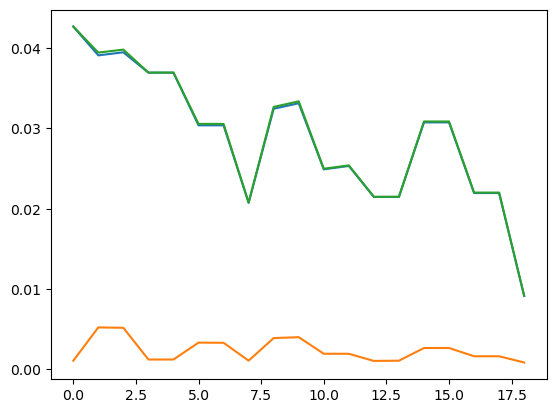

In [109]:
plt.plot(np.sqrt(np.abs(np.diag(atm_cov)))*arcsec_per_micron)
plt.plot(np.sqrt(np.diag(Cbt))*1e6*arcsec_per_micron)
plt.plot(np.sqrt(np.abs(np.diag(atm_cov)) + np.diag(Cbt)*1e12)*arcsec_per_micron)